In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator

# Load 4 bộ dữ liệu
# --- 0) Đường dẫn thư mục dữ liệu ---
base = r"C:\Downloads\Corn_data_merged_3_region"

# --- 1) Load 5 file chính ---
yield_df        = pd.read_csv(fr"{base}\Corn_yield_all_years_3region.csv")
progress_df     = pd.read_csv(fr"{base}\corn_progress_all_years_3region.csv")
condition_df    = pd.read_csv(fr"{base}\corn_condition_all_years_3region.csv")
weather_all_df  = pd.read_csv(fr"{base}\weather_weekly_all_years_3region.csv")
weather_season_df = pd.read_csv(fr"{base}\corn_weekly_merged.csv")  # file mùa vụ đã cắt theo progress


In [87]:

yield_year = (
    yield_df.groupby("year", as_index=False)["yield_grain"]
    .mean()
    .rename(columns={"yield_grain": "yield_mean"})
)


start, end = int(yield_year["year"].min()), int(yield_year["year"].max())
full_years = pd.DataFrame({"year": list(range(start, end + 1))})
yield_year = (
    full_years.merge(yield_year, on="year", how="left")
              .astype({"year": "int64"})
)

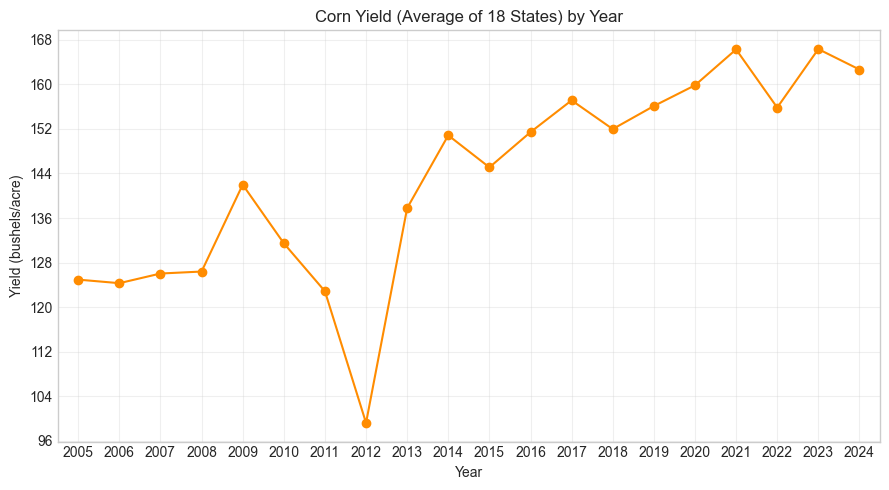

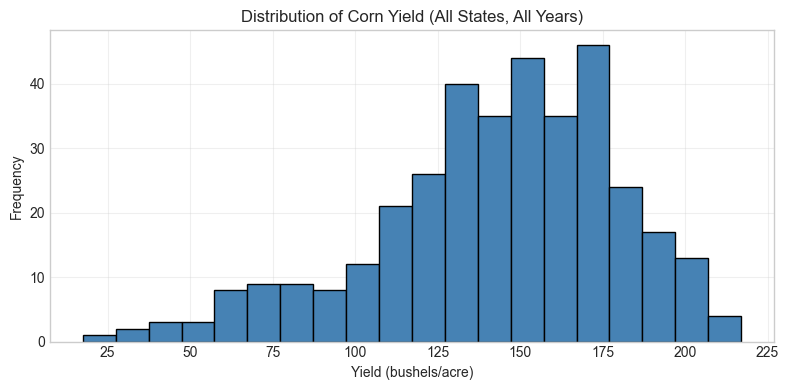

In [88]:

# 0) Chuẩn hoá cột year về số nguyên
yield_df["year"] = pd.to_numeric(yield_df["year"], errors="coerce")
yield_df["year"] = np.floor(yield_df["year"]).astype("Int64")

# 1) Tổng hợp năng suất trung bình 18 bang theo năm
yield_year = (
    yield_df.groupby("year", as_index=False)["yield_grain"]
            .mean()
            .rename(columns={"yield_grain": "yield_mean"})
)

# 2) Đảm bảo đủ các năm trong khoảng dữ liệu
ymin, ymax = int(yield_df["year"].min()), int(yield_df["year"].max())
full_years = pd.DataFrame({"year": list(range(ymin, ymax + 1))})
yield_year = full_years.merge(yield_year, on="year", how="left")

# Nếu có năm trống thì nội suy nhẹ cho mượt (tuỳ chọn)
yield_year["yield_mean"] = yield_year["yield_mean"].interpolate()

# 3) Vẽ biểu đồ xu hướng năng suất trung bình (năm là số nguyên, tick từng năm)
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(yield_year["year"], yield_year["yield_mean"], marker="o", color="darkorange")
ax.set_title("Corn Yield (Average of 18 States) by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Yield (bushels/acre)")
ax.grid(True, alpha=0.3)

# Tick năm: mỗi năm một tick và hiển thị dạng int
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(lambda x, pos: f"{int(x)}")
ax.set_xlim(ymin - 0.5, ymax + 0.5)

# (không bắt buộc) ép tick Y là số nguyên “đẹp”
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# 4) Biểu đồ phân phối năng suất (tất cả bang, tất cả năm) — dùng dữ liệu gốc, không dùng mean theo năm
plt.figure(figsize=(8, 4))
plt.hist(yield_df["yield_grain"].dropna(), bins=20, edgecolor="black", color="steelblue")
plt.title("Distribution of Corn Yield (All States, All Years)")
plt.xlabel("Yield (bushels/acre)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


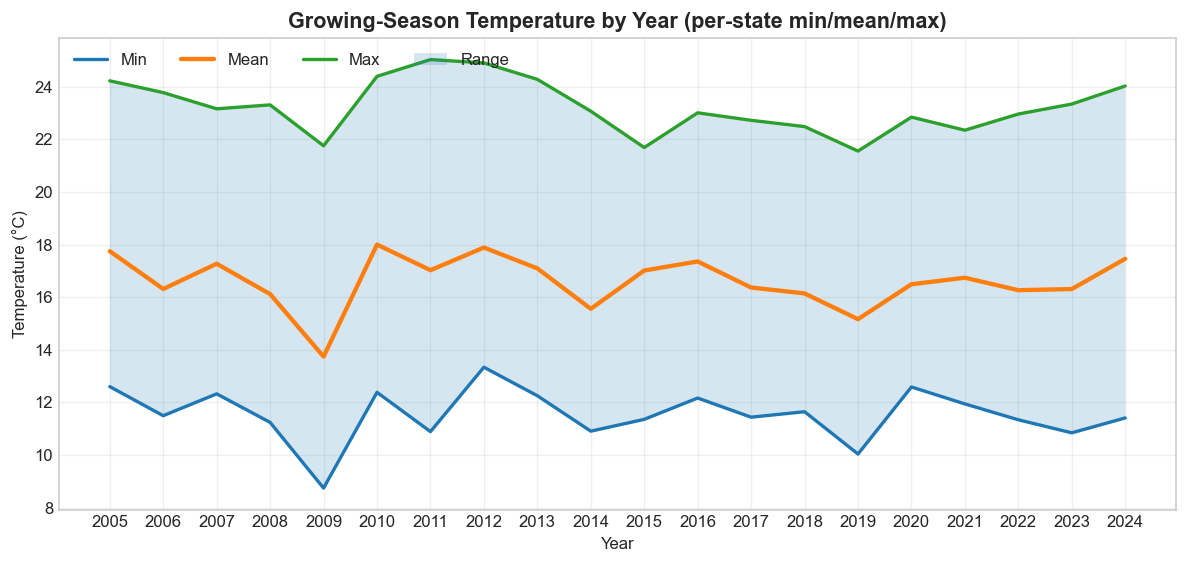

In [89]:
w = weather_season_df.copy()
w.columns = [c.lower().strip() for c in w.columns]
w["year"] = pd.to_numeric(w["year"], errors="coerce").astype("Int64")

# 1) Trung bình theo năm cho TỪNG BANG
state_year_temp = (
    w.groupby(["state_name", "year"])["tavg"]
     .mean()
     .reset_index()
)

# 2) Min/Mean/Max theo năm trên tập các bang
temp_stats = (
    state_year_temp.groupby("year")["tavg"]
                   .agg(min="min", mean="mean", max="max")
                   .reset_index()
                   .rename(columns={"min":"tmin", "mean":"tmean", "max":"tmax"})
)

# 3) Đảm bảo đủ năm và năm tròn
full_years = pd.DataFrame({"year": range(int(temp_stats["year"].min()),
                                         int(temp_stats["year"].max()) + 1)})
temp_stats = full_years.merge(temp_stats, on="year", how="left")
temp_stats["year"] = temp_stats["year"].astype(int)

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 4.8), dpi=120)
ax.plot(temp_stats["year"], temp_stats["tmin"], linewidth=2, label="Min")
ax.plot(temp_stats["year"], temp_stats["tmean"], linewidth=2.6, label="Mean")
ax.plot(temp_stats["year"], temp_stats["tmax"], linewidth=2, label="Max")
ax.fill_between(temp_stats["year"], temp_stats["tmin"], temp_stats["tmax"], alpha=0.18, label="Range")

ax.set_title("Growing-Season Temperature by Year (per-state min/mean/max)", fontsize=13, fontweight="bold")
ax.set_xlabel("Year"); ax.set_ylabel("Temperature (°C)")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticks(temp_stats["year"])
ax.set_xticklabels(temp_stats["year"], rotation=0)

ax.legend(loc="upper left", ncol=4, frameon=False)
ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

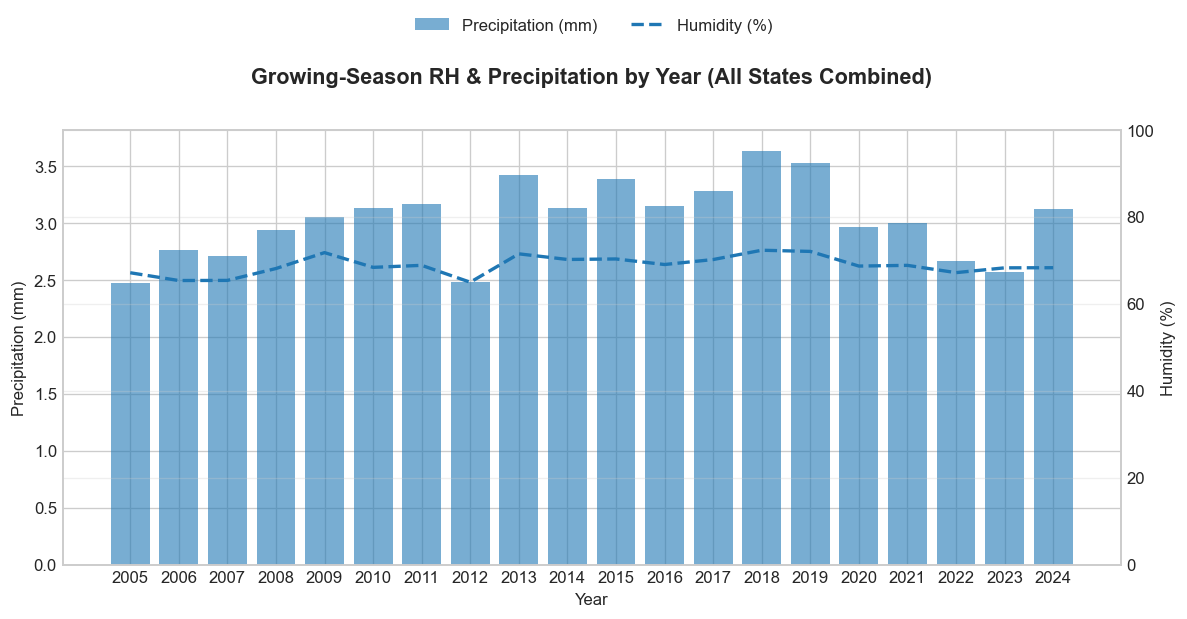

In [90]:
w = weather_season_df.copy()
w.columns = [c.lower().strip() for c in w.columns]
w["year"] = pd.to_numeric(w["year"], errors="coerce").astype("Int64")

# 1) Trung bình theo năm cho TỪNG BANG
state_year_wp = (
    w.groupby(["state_name", "year"])[["prcp_mean", "rh"]]
     .mean()
     .reset_index()
)

# 2) Trung bình toàn quốc theo năm
wp_year = (
    state_year_wp.groupby("year")[["prcp_mean", "rh"]]
                 .mean()
                 .reset_index()
)

# 3) Đảm bảo đủ năm và năm tròn
full_years = pd.DataFrame({"year": range(int(wp_year["year"].min()),
                                         int(wp_year["year"].max()) + 1)})
wp_year = full_years.merge(wp_year, on="year", how="left")
wp_year["year"] = wp_year["year"].astype(int)

# 4) Plot: Precip = cột (trục trái), RH = đường (trục phải)
fig, ax1 = plt.subplots(figsize=(10, 4.8), dpi=120)

ax1.bar(wp_year["year"], wp_year["prcp_mean"], alpha=0.6, label="Precipitation (mm)", width=0.8)
ax1.set_xlabel("Year"); ax1.set_ylabel("Precipitation (mm)")
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.set_xticks(wp_year["year"])
ax1.set_xticklabels(wp_year["year"], rotation=0)

ax2 = ax1.twinx()
ax2.plot(wp_year["year"], wp_year["rh"], linestyle="--", linewidth=2, label="Humidity (%)")
ax2.set_ylabel("Humidity (%)"); ax2.set_ylim(0, 100)

# Legend tách riêng
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, 1.08),
           ncol=2, frameon=False)

plt.title("Growing-Season RH & Precipitation by Year (All States Combined)", fontsize=13, fontweight="bold", pad=28)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

       Stage  Start_Week  Peak_Week  End_Week  Duration_Weeks     Peak_%
0    Planted           9         21        29              21  78.222222
1    Emerged          17         24        30              14  85.148936
2    Silking          26         31        39              14  90.072222
3   Doughing          29         35        43              15  85.755556
4     Dented          31         37        45              15  86.938889
5     Mature          34         40        48              15  85.807018
6  Harvested          36         52        52              17  99.000000


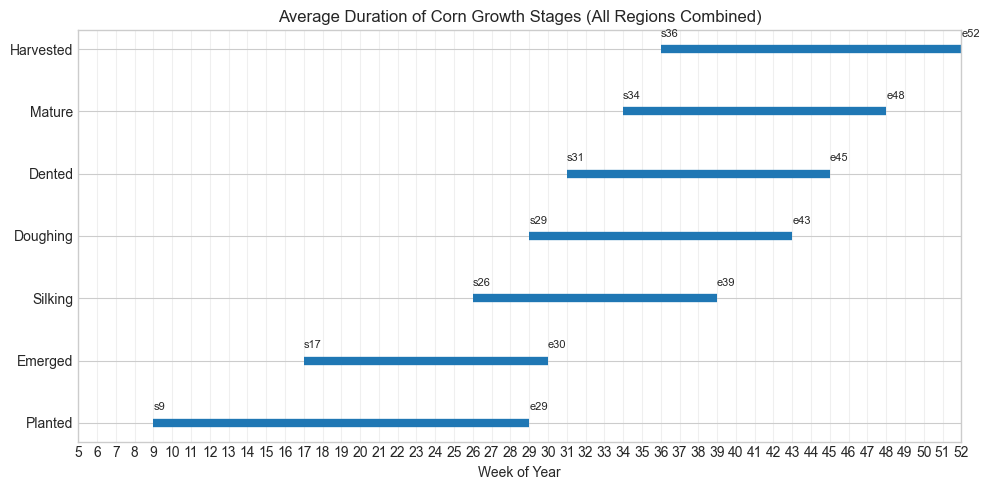

In [101]:

progress_df.columns = [c.lower().strip() for c in progress_df.columns]
progress_df["week_ending"] = pd.to_datetime(progress_df["week_ending"], errors="coerce")
progress_df["week_of_year"] = progress_df["week_ending"].dt.isocalendar().week.astype(int)

stage_cols = [c for c in ["planted","emerged","silking","doughing","dented","mature","harvested"] if c in progress.columns]

# --- Trung bình toàn vùng theo tuần ---
weekly = (
    progress.groupby("week_of_year")[stage_cols]
    .mean(numeric_only=True)
    .sort_index()
)

# --- Tính tuần bắt đầu (>=10%), đỉnh, kết thúc (>0) ---
summary = []
for st in stage_cols:
    s = weekly[st].fillna(0)
    if (s > 0).any():
        # bắt đầu khi >=10% để tránh nhiễu
        valid = s[s >= 10]
        if len(valid) > 0:
            start_w = int(valid.index[0])
        else:
            start_w = int(s.index[s > 0][0])
        peak_w  = int(s.idxmax())
        end_w   = int(s.index[s > 0][-1])
        duration = end_w - start_w + 1
        summary.append({
            "Stage": st.capitalize(),
            "Start_Week": start_w,
            "Peak_Week": peak_w,
            "End_Week": end_w,
            "Duration_Weeks": duration,
            "Peak_%": float(s.max())
        })

summary_df = pd.DataFrame(summary)
print(summary_df)

# --- Biểu đồ thanh thời gian (timeline) ---
fig, ax = plt.subplots(figsize=(10, 5))
ypos = np.arange(len(summary_df))
for i, row in summary_df.iterrows():
    ax.hlines(y=i, xmin=row["Start_Week"], xmax=row["End_Week"], linewidth=6, color="tab:blue")
    ax.text(row["Start_Week"], i + 0.2, f"s{int(row['Start_Week'])}", fontsize=8)
    ax.text(row["End_Week"], i + 0.2, f"e{int(row['End_Week'])}", fontsize=8)

ax.set_yticks(ypos)
ax.set_yticklabels(summary_df["Stage"])
ax.set_xlabel("Week of Year")
ax.set_title("Average Duration of Corn Growth Stages (All Regions Combined)")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlim(5, 52)
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()
